# Các mẫu thiết kế GOF : Abstract factory

**BS. Lê Ngọc Khả Nhi**

# Giới thiệu

Abstract Factory là một mẫu thiết kế thuộc nhóm "Tạo lập" (Creational), nó cho phép người dùng tạo ra đồng thời nhiều đối tượng có liên hệ với nhau (cùng thuộc về một họ/nhóm/loại nào đó tùy chọn), và sử dụng các method từ những đối tượng này, mà không cần phải bận tâm về cấu tạo chi tiết những class chuyên biệt cho mỗi tùy chọn.

# Thí dụ minh họa

Định nghĩa trên có thể chưa rõ ràng lắm (Nhi cũng cảm thấy như vậy), do đó cách tốt nhất là dùng một thí dụ minh họa. Trong thí dụ này, Một nhóm nghiên cứu muốn thực hiện phân tích thời gian sự kiện (Survival analysis) cho một dữ liệu về tiên lượng sống còn của bệnh Ung thư phổi. Tuy nhiên 2 bác sĩ trong nhóm cứ tranh cãi với nhau, một người muốn dùng phương pháp semi-parametric là mô hình Cox-PH truyền thống, một người lại muốn dùng mô hình Survival parametric với phân phối Weibull. Do đó, chuyên viên lập trình thống kê được yêu cầu thiết kế một chương trình cho phép lựa chọn giữa 2 cách làm, thông qua một keyword, 

Khi bác sĩ A nhập keyword = 'coxph', chương trình sẽ thực hiện 2 bước: Thăm dò trực quan qua biểu đồ Kaplan-Meier; sau đó khớp một mô hình hồi quy CoxPH và xuất kết quả mô hình.

Khi bác sĩ B nhập keyword 'weibull', chương trình sẽ vẽ đồ thị hàm Survival với phân phối Weibull; sau đó khớp một mô hình Survuval parametric Weibull và xuất kết quả mô hình.


# Giải quyết vấn đề bằng thiết kế Abstract factory

Phân tích vấn đề, ta hình dung chương trình như 1 nhà máy (Factory) sản xuất ra sản phẩm là kết quả phân tích. 2 quy trình CoxPH và Weibull có thể xem là 2 dòng sản phẩm ta cần. Như một xưởng may làm ra 2 bộ thời trang mùa Đông và mùa Hè, nhưng cả 2 đều có quần và áo - tương đương 2 công đoạn : vẽ biểu đồ và khớp mô hình trong mỗi quy trình. Ta có thể xem Biểu đố là 1 class, và Mô hình là 1 class khác. Như vậy cho mỗi lựa chọn (quy trình), ta cần những class chuyên biệt :

+ Quy trình CoxPH (A): Class Kaplan_Meier_Curve và class CoxPH;

+ Quy trình Weibull (B): Class Weibull_curve và Weibull_model;

+ Ta thiết kế 1 interface Explorer (1) cho 2 classes Kaplan_Meier_Curve và Weibull_curve;

+ và thiết kế 1 interface Survival_model (2) cho 2 classes Cox_PH và Weibull_model;

Việc ghép cặp các object sinh ra từ concrete class của Curve và Model, có thể được thực hiện thông qua lập trình hướng đối tượng với 1 class giao diện người dùng; hoặc sử dụng lập trình hàm. Trong bài này, Nhi dùng cách thứ hai, với lập trình hàm và dùng trực tiếp một cấu trúc dữ liệu trong Python là dictionary (3) với key = tên của quy trình, và value là 1 tuple gồm 2 object curve, model tương ứng.

Cuối cùng, End user code sẽ vận hành 2 hàm rời để tạo ra 1 method là 1 tuple gồm curve và model chuyên biệt và sử dụng method này để xuất kết quả.

Sơ đồ UML của chương trình như sau:

!['uml'](abstract_factory.png)

Nội dung của code nằm tại thư mục Github sau:

https://github.com/kinokoberuji/Python-snipets/blob/master/GOF/Abstract_Factory/Abstract_Factory.py

# Triển khai chương trình

In [ ]:
import pandas as pd
from typing import Protocol, Tuple
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from lifelines import CoxPHFitter, KaplanMeierFitter, WeibullFitter, WeibullAFTFitter


@dataclass
class Explorer(Protocol):

    data: pd.DataFrame = field(init=True)

    def data_viz(self, time_col: str, event_col: str) -> None:
        """Vẽ biểu đồ khảo sát dữ liệu Thời gian/Sự kiện"""


@dataclass
class Kaplan_Meier_Curve:

    data: pd.DataFrame = field(init=True)

    def data_viz(self, time_col: str, event_col: str) -> None:
        """Vẽ biểu đồ Kaplan-Meier"""
        data = self.data.copy()

        kmf = KaplanMeierFitter().fit(
            data[time_col], data[event_col], label="Kaplan-Meier"
        )
        kmf.plot_survival_function(color="#e60e56")
        plt.title("Biểu đồ Kaplan-Meier")
        plt.xlabel("Thời gian (ngày")
        plt.ylabel("Xác suất sống còn tích lũy")
        plt.show()


@dataclass
class Weibull_Curve:

    data: pd.DataFrame = field(init=True)

    def data_viz(self, time_col: str, event_col: str) -> None:
        """Vẽ biểu đồ Kaplan-Meier"""
        data = self.data.copy()

        wf = WeibullFitter().fit(data[time_col], data[event_col], label="Weibull")
        wf.plot_survival_function(color="#680fa8")
        plt.title("Đồ thị hàm survival với phân phối Weibull")
        plt.xlabel("Thời gian (ngày")
        plt.ylabel("Xác suất sống còn tích lũy")
        plt.show()


@dataclass
class Survival_model(Protocol):

    data: pd.DataFrame = field(init=True)

    def fit_model(self, time_col: str, event_col: str) -> None:
        """Khớp mô hình survival"""

    def summary(self) -> None:
        """Tóm tắt mô hình"""

    def plot_survival_function(self, idx: int) -> None:
        """Vẽ biểu đồ khảo sát dữ liệu Thời gian/Sự kiện"""


@dataclass
class CoxPH:

    data: pd.DataFrame = field(init=True)
    model = CoxPHFitter()

    def fit_model(self, time_col: str, event_col: str) -> None:
        """Khớp mô hình hồi quy CoxPH"""

        data = self.data.copy()
        self.model.fit(data, time_col, event_col)

    def summary(self) -> None:
        try:
            self.model.print_summary()
            self.model.plot()
            plt.show()
        except:
            print("Cần khớp Mô hình CoxPH với dữ liệu trước")

    def plot_survival_function(self, idx: int) -> None:
        try:
            X = self.data.iloc[idx]
        except IndexError:
            print(f"Trường hợp {idx} không tồn tại trong dữ liệu")

        try:
            self.model.predict_survival_function(X).rename(columns={idx: "CoxPH"}).plot(
                color="#e60e56"
            )
            plt.title(f"Biểu đồ hồi quy CoxPH với dữ liệu {idx}")
            plt.xlabel("Thời gian (ngày")
            plt.ylabel("Xác suất sống còn tích lũy")
            plt.show()
        except:
            print("Cần khớp Mô hình CoxPH với dữ liệu trước")


@dataclass
class Weibull_model:

    data: pd.DataFrame = field(init=True)
    model = WeibullAFTFitter()

    def fit_model(self, time_col: str, event_col: str) -> None:
        """Khớp mô hình hồi quy với phân phối Weibull"""

        data = self.data.copy()
        self.model.fit(data, time_col, event_col)

    def summary(self) -> None:
        try:
            self.model.print_summary()
            self.model.plot()
            plt.show()
        except:
            print("Cần khớp Mô hình Weibull với dữ liệu trước")

    def plot_survival_function(self, idx: int) -> None:

        try:
            X = self.data.iloc[idx]
        except IndexError:
            print(f"Trường hợp {idx} không tồn tại trong dữ liệu")

        try:
            self.model.predict_survival_function(X).rename(
                columns={idx: "Weibull"}
            ).plot(color="#680fa8")
            plt.title(f"Biểu đồ hồi quy Weibull với dữ liệu {idx}")
            plt.xlabel("Thời gian (ngày")
            plt.ylabel("Xác suất sống còn tích lũy")
            plt.show()
        except:
            print("Cần khớp Mô hình Weibull với dữ liệu trước")


CONFIGS = {
    "coxph": (Kaplan_Meier_Curve, CoxPH),
    "weibull": (Weibull_Curve, Weibull_model),
}


def generate_methods(data: pd.DataFrame) -> Tuple[Explorer, Survival_model]:
    """Khởi tạo 2 object khảo sát dữ liệu và mô hình survival"""

    while True:
        configs = input(f"Hãy chọn 1 trong 2 phương pháp {', '.join(CONFIGS)}: ")

        try:
            (curve, model) = CONFIGS[configs]
            return (curve(data), model(data))
        except KeyError:
            print(f"Tên phương pháp {configs} không hợp lệ !")


def survival_analysis(
    methods: Tuple[Explorer, Survival_model], time_col: str, event_col: str
):
    """Thực hiện phân tích Survival với method thùy chọn"""

    curve, model = methods
    curve.data_viz(time_col, event_col)
    model.fit_model(time_col, event_col)

    return model

# Sử dụng chương trình

In [2]:
from Abstract_Factory import *

Nhi tải bộ dữ liệu Lung cancer về máy để làm phân tích: Đây là 1 dữ liệu Survival analysis điển hình với 2 cột time chỉ thời gian và status chỉ biến cố tử vong hay censored; cùng 7 biến độc lập khác trong mô hình.

In [3]:
df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/survival/cancer.csv', index_col = 0)
df = df.iloc[:,1:]
df.dropna(axis = 0, inplace = True)
df['sex'] = df['sex'] - 1
df['status'] = df['status'] - 1

df

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
2,455,1,68,0,0.0,90.0,90.0,1225.0,15.0
4,210,1,57,0,1.0,90.0,60.0,1150.0,11.0
6,1022,0,74,0,1.0,50.0,80.0,513.0,0.0
7,310,1,68,1,2.0,70.0,60.0,384.0,10.0
8,361,1,71,1,2.0,60.0,80.0,538.0,1.0
...,...,...,...,...,...,...,...,...,...
222,203,0,71,1,1.0,80.0,90.0,1025.0,0.0
225,191,0,39,0,0.0,90.0,90.0,2350.0,-5.0
226,105,0,75,1,2.0,60.0,70.0,1025.0,5.0
227,174,0,66,0,1.0,90.0,100.0,1075.0,1.0


## Quy trình Cox-PH và Kaplan-Meier curve

Khi gọi hàm generate_methods(), ta sẽ được yêu cầu nhập tên method, nếu là coxph, ta sẽ làm quy trình Cox-PH kết hợp KM curve:

In [4]:
method_1 = generate_methods(df)

Hãy chọn 1 trong 2 phương pháp coxph, weibull: coxph


ibject method_1 mà ta vừa tạo là 1 tuple, nó chứa 2 object khác của 2 concrete classes là Kaplan_Meier_curve và CoxPH. Ta gọi tiếp hàm survival_analysis với method_1 object vừa tạo ra, nó sẽ xuất ra 1 object mô hình coxph và in kết quả gồm biểu đồ Kaplan-Meier, và diễn giải nội dung mô hình CoxPH

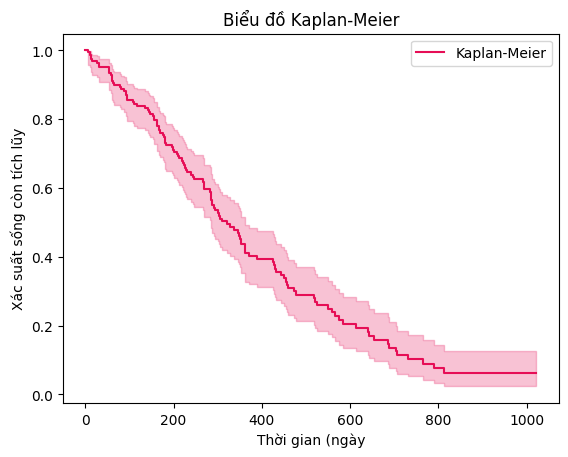

In [5]:
coxph_mod = survival_analysis(method_1,
                              time_col= 'time',
                              event_col = 'status')

<lifelines.CoxPHFitter: fitted with 168 total observations, 47 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 168
number of events observed = 121
   partial log-likelihood = -498.75
         time fit was run = 2021-09-17 16:49:35 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
sex        -0.55       0.58       0.20            -0.94            -0.16                 0.39                 0.85
ph.ecog     0.73       2.08       0.22             0.30             1.17                 1.35                 3.23
ph.karno    0.02       1.02       0.01             0.00             0.04                 1.00                 1.05
pat.karno  -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00
meal.cal    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
wt.loss    -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00

              z      p   -log2(p)
covariate                        
age        0.92   0.36       1.48
sex       -2.74   0.01       7.36
ph.ecog    3.29 <0.005       9.95
ph.karno   2.00   0.05       4.45
pat.karno -1.54   0.12       3.02
meal.cal   0.13   0.90       0.16
wt.loss   -1.84   0.07       3.94
---
Concordance = 0.65
Partial AIC = 1011.50
log-likelihood ratio test = 28.33 on 7 df
-log2(p) of ll-ratio test = 12.35

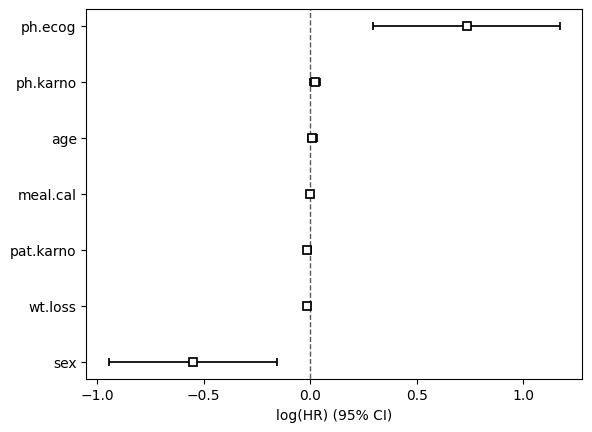

In [6]:
coxph_mod.summary()

Ta có thể dùng method plot_survival_function để vẽ đồ thị hàm survival cho kết quả tiên lượng của 1 cá thể tùy chọn, tùy theo index của cá thể đó:

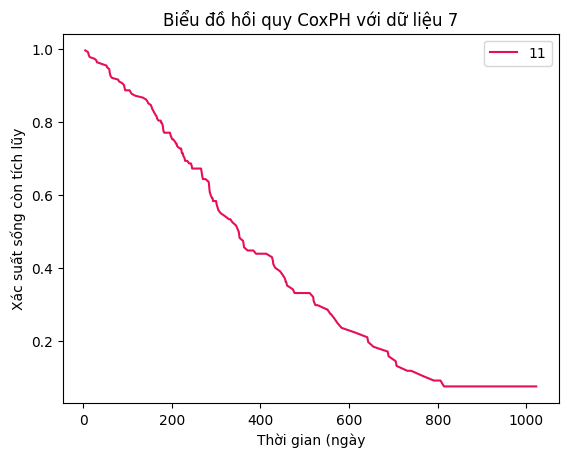

In [7]:
coxph_mod.plot_survival_function(idx = 7) # Hàng thứ 7

## Quy trình Weibull

Nhi lại gọi hàm generate_methods() lần nữa để chọn con đường Weibull:

In [8]:
method_2 = generate_methods(df)

Hãy chọn 1 trong 2 phương pháp coxph, weibull: weibull


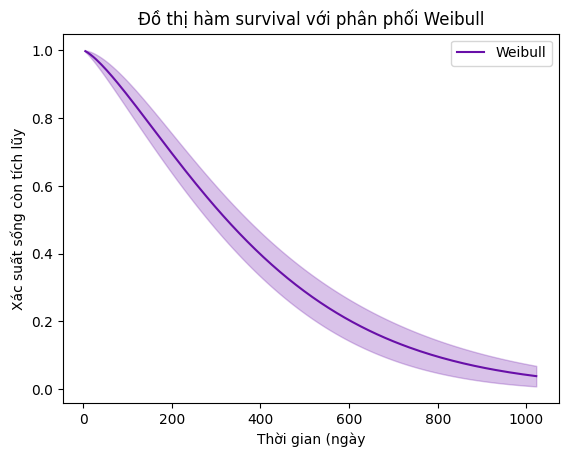

In [9]:
wb_mod = survival_analysis(method_2,
                              time_col= 'time',
                              event_col = 'status')

<lifelines.WeibullAFTFitter: fitted with 168 total observations, 47 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 168
number of events observed = 121
           log-likelihood = -833.38
         time fit was run = 2021-09-17 16:53:28 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ age        -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
        meal.cal   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        pat.karno   0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
        ph.ecog    -0.52       0.59       0.15            -0.82            -0.22                 0.44                 0.80
        ph.karno   -0.02       0.98       0.01            -0.03            -0.00                 0.97                 1.00
        sex         0.39       1.47       0.14             0.11             0.66                 1.12                 1.94
        wt.loss     0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
        Intercept   7.38    1606.99       1.05             5.32             9.44               205.06             12593.22
rho_    Intercept   0.36       1.44       0.07             0.22             0.50                 1.25                 1.66

                      z      p   -log2(p)
param   covariate                        
lambda_ age       -0.81   0.42       1.25
        meal.cal  -0.07   0.94       0.08
        pat.karno  1.56   0.12       3.06
        ph.ecog   -3.42 <0.005      10.63
        ph.karno  -2.17   0.03       5.07
        sex        2.75   0.01       7.40
        wt.loss    1.77   0.08       3.71
        Intercept  7.03 <0.005      38.79
rho_    Intercept  5.03 <0.005      20.99
---
Concordance = 0.65
AIC = 1684.76
log-likelihood ratio test = 28.48 on 7 df
-log2(p) of ll-ratio test = 12.44

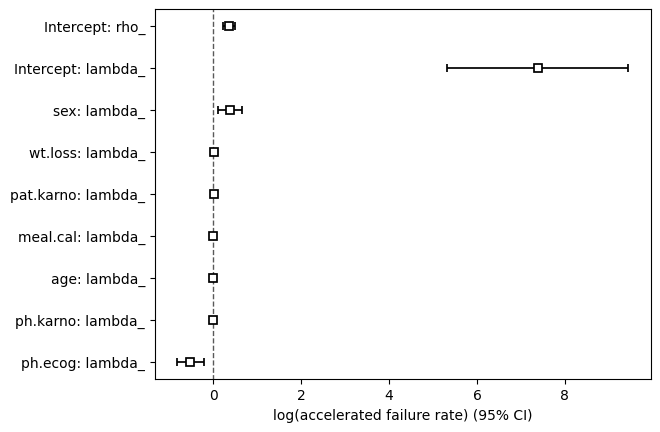

In [10]:
wb_mod.summary()

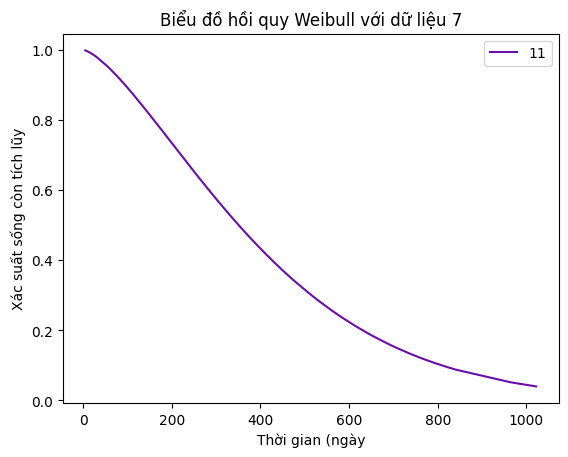

In [11]:
wb_mod.plot_survival_function(idx = 7) # Hàng thứ 7

# Bàn luận về ưu và nhược điểm của thiết kế

Thiết kế Abstract factory có nhiều ưu thế:

Nó cho phép tạo ra đồng loạt tất cả sản phẩm (concrete class/object) cùng thuộc về một dòng sản phẩm (họ quy trình) và đảm bảo các object này tương thích với nhau, chuyên biệt cho mỗi họ/nhóm quy trình.

Tương tự như thiết kế Method factory mà Nhi từng giới thiệu, khi dùng Abstract factory , người dùng không cần phải nắm rõ cấu trúc/nội dung bên trong chương trình hay vai trò của từng concrete class chuyên biệt để khởi tạo object mà mình cần, nhưng chỉ cần tương tác với 1 giao diện trừu tượng và đơn giản để nhận kết quả.

Tuân thủ quy tắc Single Responsibility, đảm bảo mỗi class chỉ đảm nhận một nhiệm vụ duy nhất,làm cho việc bảo trì code được dễ dàng hơn.

Tuân thủ quy tắc Open/Close: cho phép mở rộng tính năng cho chương trình mà không cần thay đổi nội dung code trong những class đã có. Trong thí dụ này, ta có thể tạo ra quy trình thứ 3, 4 với nhiều loại mô hình Survival khác ngoài 2 mô hình vừa nêu chỉ bằng cách thêm class Curve và Model mới, cùng thay đổi nội dung method bên trong chúng.

Nhược điểm là cấu trúc chương trình có thể trở nên phức tạp quá mức theo thời gian, cần nhiều subclass chỉ để làm vài công đoạn nhỏ trong khi ta hoàn toàn có thể dùng lập trình hàm.

Bài thực hành chấm dứt, chúc các bạn thực hành vui.